# **MAIN PROJECT NLP**

## **Emotion Discovery and Reasoning its Flip in Conversation (EDiReF)**

### **TASK 1 - Corpus**

In [1]:
# This is needed if the nootebok is running from colab

!pip install datasets==2.13.2
!pip install accelerate -U
!pip install evaluate
!pip install googledrivedownloader

#from google.colab import drive
#drive.mount('/content/drive')

   ---------------------------------------- 0.0/270.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/270.9 kB 660.6 kB/s eta 0:00:01
   ----- --------------------------------- 41.0/270.9 kB 495.5 kB/s eta 0:00:01
   ----------- --------------------------- 81.9/270.9 kB 657.6 kB/s eta 0:00:01
   --------------- ---------------------- 112.6/270.9 kB 595.3 kB/s eta 0:00:01
   ----------------- -------------------- 122.9/270.9 kB 602.4 kB/s eta 0:00:01
   ----------------- -------------------- 122.9/270.9 kB 602.4 kB/s eta 0:00:01
   ----------------- -------------------- 122.9/270.9 kB 602.4 kB/s eta 0:00:01
   ------------------------------- ------ 225.3/270.9 kB 599.0 kB/s eta 0:00:01
   ---------------------------------- --- 245.8/270.9 kB 603.9 kB/s eta 0:00:01
   -------------------------------------- 270.9/270.9 kB 596.4 kB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.25.0
    Uninstalling accelerate-0.25.0:
      S

In [1]:
# dataset opening
import json
import pandas as pd
import os
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd


# utils
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch.nn.functional as F

# models
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import Dataset
from collections import Counter

from transformers import AutoTokenizer, AdamW, BertModel
from sklearn.utils.class_weight import compute_class_weight
from torch.nn.utils.rnn import pad_sequence
import evaluate
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using CUDA!')
else:
    device = torch.device("cpu")
    print('CUDA not available...using CPU')

Using CUDA!


In [4]:
random_seed1 = 101
random_seed2 = 102
random_seed3 = 103
random_seed4 = 104
random_seed5 = 105

# Set random seed 1 as default for all processes of the notebook apart from the inizialization of the models
random.seed(101)
np.random.seed(101)

##### 1.1 Encoding the dataframe in a pandas structure

In [5]:
def dataset_encoder(dataset_path):
    with open(dataset_path, 'r') as file:
        data = json.load(file)
    random.seed(random_seed1)
    random.shuffle(data)

    rows = []
    count = 0
    for episode in data:
        for i in range(len(episode['speakers'])):
            row = {
                'episode' : episode['episode'],
                'speaker' : episode['speakers'][i],
                'emotion' : episode['emotions'][i],
                'utterance' : episode['utterances'][i],
                'trigger' : episode['triggers'][i],
                'lunghezza' : count
            }
            rows.append(row)
        count += 1

    df = pd.DataFrame(rows)
    return df

def NaN_handler(df):
    nan_count = df.isna().sum().sum()
    print(f'There were {nan_count} NaNs in the dataframe')
    df.fillna(0, inplace=True)
    return df

def plot_distribution(df, column, xlabel, title):
    count_dict = {}
    for value in df[column]:
        if value not in count_dict:
            count_dict[value] = 1
        else:
            count_dict[value] += 1

    print(count_dict)
    keys = list(count_dict.keys())
    values = list(count_dict.values())

    plt.bar(keys, values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(keys, keys)
    plt.show()

# This function visualize the utterances length distribution and generate a red line below which "treshold" % of data is located
def plot_sentence_length_boxplot(dataframe, threshold_percent=99):

    df_copy = dataframe.copy()
    # Calculate the length of each sentence in the 'Text' column
    df_copy['Text_length'] = df_copy['utterance'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(5, 3))
    sns.boxplot(y='Text_length', data=df_copy, color='lightblue')

    # Add a red line for the threshold
    threshold_value = np.percentile(df_copy['Text_length'], threshold_percent)
    plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'{threshold_percent}% Threshold')

    plt.title('Boxplot of Sentence Length')
    plt.ylabel('Sentence Length')
    plt.legend()
    plt.show()

    return int(threshold_value)

# Function to encode the 'emotion' column
def encode_labels(df):
    # Encode emotions
    emotion_classes = df['emotion'].unique()
    emotion_mapping = {emotion: idx for idx, emotion in enumerate(emotion_classes)}
    df['emotion'] = df['emotion'].map(emotion_mapping)

    # Encode triggers
    trigger_classes = df['trigger'].unique()
    trigger_mapping = {trigger: idx for idx, trigger in enumerate(trigger_classes)}
    df['trigger'] = df['trigger'].map(trigger_mapping)

    # Create reverse mapping for emotions
    reverse_emotion_mapping = {idx: emotion for emotion, idx in emotion_mapping.items()}

    # Create reverse mapping for triggers
    reverse_trigger_mapping = {idx: trigger for trigger, idx in trigger_mapping.items()}

    return df, reverse_emotion_mapping, reverse_trigger_mapping

In [6]:
# This is needed if the nootebok is running from colab
#dest_path = '/content/drive/MyDrive/Project/MELD_train_efr.json'

dest_path = './Datasets/MELD_train_efr.json'


gdd.download_file_from_google_drive(file_id='1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2',
                                    dest_path=dest_path,
                                    unzip=False)

file_path = os.path.abspath(dest_path)

df = dataset_encoder(file_path)
df = NaN_handler(df)

There were 9 NaNs in the dataframe


In [7]:
# Concatenate speaker and utterance
df['Text'] = df['speaker'] + [' '] + df['utterance']
df['Text'] = df['Text'].str.lower()

# Encode emotion in numeric format
df, reverse_emotion_mapping, reverse_trigger_mapping = encode_labels(df)
df.head()

,episode,speaker,emotion,utterance,trigger,lunghezza,Text
0,utterance_2243,Ross,0,Of course he is!,0,0,ross of course he is!
1,utterance_2243,Ross,0,"What, do you think I'd just use my son as-as a...",0,0,"ross what, do you think i'd just use my son as..."
2,utterance_2243,Ross,1,What kind of father do you think I am?,1,0,ross what kind of father do you think i am?
3,utterance_579,Joey,2,"Monica face it, Chandler is against marriage. ...",0,1,"joey monica face it, chandler is against marri..."
4,utterance_579,Monica,1,Well there's some people who do want to marry me.,0,1,monica well there's some people who do want to...


#### 1.2 Visualize the distribution of emotions and triggers for each utterance

{0: 6317, 1: 3964, 2: 15263, 3: 4645, 4: 1049, 5: 2648, 6: 1114}


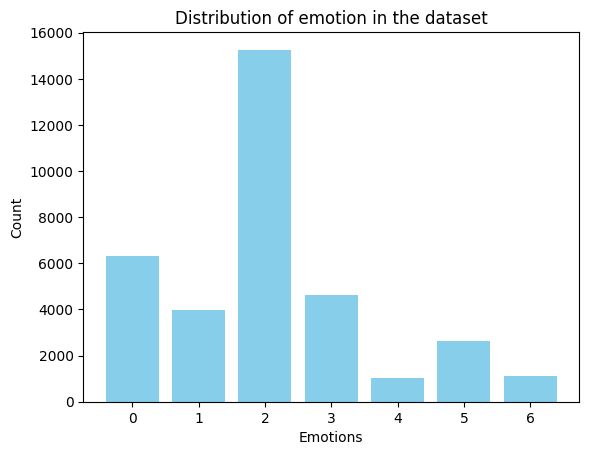

{0: 29425, 1: 5575}


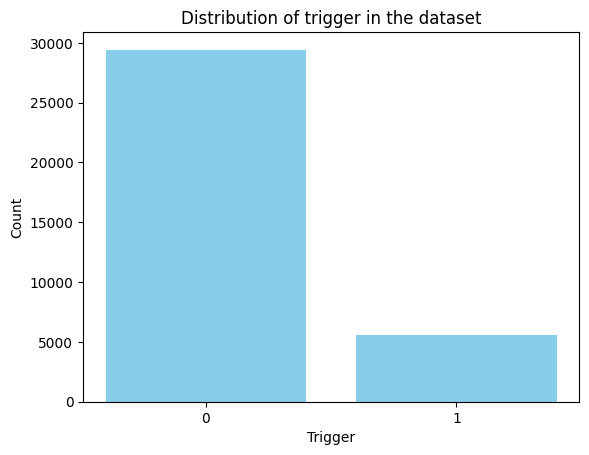

In [8]:
plot_distribution(df, 'emotion', 'Emotions', 'Distribution of emotion in the dataset')
plot_distribution(df, 'trigger', 'Trigger', 'Distribution of trigger in the dataset')

Now we visualize length of utterances and choose a maximum sequence length after which longer utterances will be truncated. This is due to the fact that by using the maximum sequence length of the dataset we will have unusually long padding, because even shorter phrases will have a high amount of pad tokens. To speed up computation we choose a lower value, equal to 28 because at least 99 % of utterances are shorter than 28 words and so we will not loose information on the vast majority of them by truncating. We add one to consider also the speaker (Added in the Text column) and another one to consider the lower end of 99 (99.6% instead of 99.1%).

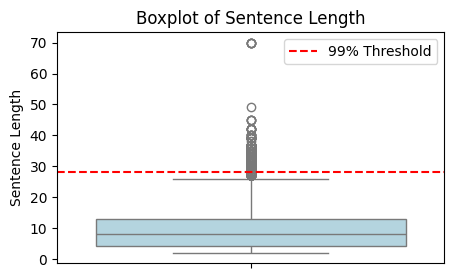

The max sequence length is 30 words


In [14]:
max_sequence_length = plot_sentence_length_boxplot(df)
MAX_SEQUENCE_LENGTH = max_sequence_length + 2
print(f"The max sequence length is {MAX_SEQUENCE_LENGTH} words")

#### 1.3 Change structure to be at Dialogue-level and split data

In [10]:
def split(df):
  train = df.iloc[:3200]
  val = df.iloc[3200:3600]
  test = df.iloc[3600:]
  return train, val, test

def Dialogue_constructor(df, model_card, tokenizer):

  listE = []
  listT = []
  listL = []
  ListInputids = []
  ListAttentionMask = []

  def preprocess_text(texts):
      return tokenizer(texts, padding=True, truncation=True, max_length=MAX_SEQUENCE_LENGTH)

  for lunghezza, group in df.groupby('lunghezza'):
          emotion_concatenated = group['emotion'].tolist()
          trigger_concatenated = group['trigger'].tolist()

          # Use the tokenizer and extract input_ids and attention_mask from the returned dictionary
          processed_texts = [preprocess_text(text) for text in group['Text']]
          input_ids = [text['input_ids'] for text in processed_texts]
          attention_mask = [text['attention_mask'] for text in processed_texts]

          max_length = MAX_SEQUENCE_LENGTH

          # Pad the lists to the maximum length
          input_ids = [lst + [0] * (max_length - len(lst)) for lst in input_ids]
          attention_mask = [lst + [0] * (max_length - len(lst)) for lst in attention_mask]

          listE.append(emotion_concatenated)
          ListInputids.append(input_ids)
          ListAttentionMask.append(attention_mask)
          listT.append(trigger_concatenated)
          listL.append(lunghezza)

  return listE, listT, ListInputids, ListAttentionMask, listL

In [11]:
# Create new dataframe
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

Emotions, Triggers, inputIDS, attentionMASK, listL = Dialogue_constructor(df, model_card, tokenizer)
new_df = pd.DataFrame({'emotion_labels': Emotions, 'trigger_labels': Triggers, 'input_ids': inputIDS, 'attention_mask': attentionMASK, 'index': listL})

# Check new structure
print('shape:', new_df.shape)
new_df.head()

shape: (4000, 5)


,emotion_labels,trigger_labels,input_ids,attention_mask,index
0,"[0, 0, 1]","[0, 0, 1]","[[101, 5811, 1997, 2607, 2002, 2003, 999, 102,...","[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,...",0
1,"[2, 1, 3, 1, 3, 2]","[0, 0, 0, 0, 0, 0]","[[101, 9558, 9018, 2227, 2009, 1010, 13814, 20...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1
2,"[2, 0, 0, 3, 2, 3, 2, 3, 1, 3, 3, 4, 5, 1, 2, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[[101, 9036, 2182, 2017, 2175, 1012, 102, 0, 0...","[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,...",2
3,"[2, 0, 2, 3, 3, 1, 2, 4, 2, 4, 2, 4, 2, 3, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[101, 9018, 2242, 2253, 3308, 2007, 2104, 161...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",3
4,"[5, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 4, 2, 4, 3]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[[101, 2720, 1012, 13012, 10322, 25443, 10657,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",4


In [12]:
# performing an 80/10/10 split
train, val, test = split(new_df)
print(f'SIZES RECAP:\nTrain size: {train.shape[0]} rows\nValidation size: {val.shape[0]} rows\nTest size: {test.shape[0]} rows')

SIZES RECAP:
Train size: 3200 rows
Validation size: 400 rows
Test size: 400 rows


##### 1.4 Prepare the data for the models

In [13]:
def data_preprocesser(train, val, test):

    train_data = Dataset.from_pandas(train)
    val_data = Dataset.from_pandas(val)
    test_data = Dataset.from_pandas(test)

    return train_data, val_data, test_data

def obtain_input(dataset, batch_size=1):

    # Turn into numpy array to ensure speed up in conversion of datatype
    input_ids = np.array(dataset['input_ids'], dtype=object)
    attention_mask = np.array(dataset['attention_mask'], dtype=object)
    emotion = np.array(dataset['emotion_labels'], dtype=object)
    trigger = np.array(dataset['trigger_labels'], dtype=object)

    num_samples = len(dataset['input_ids'])
    dialogue_list = []

    # Create dataloader object
    for i in range(0, num_samples - batch_size + 1, batch_size):
        input_ids_batch = input_ids[i:i+batch_size].tolist()
        attention_mask_batch = attention_mask[i:i+batch_size].tolist()
        emotion_batch = emotion[i:i+batch_size].tolist()
        trigger_batch = trigger[i:i+batch_size].tolist()

        dialogue_list.append([input_ids_batch, attention_mask_batch, emotion_batch, trigger_batch])

    return dialogue_list

In [13]:
# Turn train val and test in datasets object
train_data, val_data, test_data = data_preprocesser(train, val, test)

# Turn in customized dataloader object for use as model inputs
train_dataloader = obtain_input(train_data, batch_size=1)
val_dataloader = obtain_input(val_data, batch_size=1)
test_dataloader = obtain_input(test_data, batch_size=1)

## **TASK 2 - Metrics**

### 2.1 Baseline metric

Code we use to evaluate the majority and random classifier

In [14]:
def evaluate_baseline(baseline, label, test):

  predictions_maj = baseline.predict_majority(test, label)
  predictions_ran = baseline.predict_random(test, label)

  macro_maj = baseline.macro_f1_score(predictions_maj, test, label)
  macro_ran = baseline.macro_f1_score(predictions_ran, test, label)

  return macro_maj, macro_ran

### 2.2 Bert metric
The code we use to evaluate Bert models.

In [15]:
def evaluate_metrics(name, true_labels_all, predictions_all):

    labels = [x.to(device).tolist() for x in true_labels_all]
    labels = [x for y in labels for x in y]

    preds = [x.to(device).tolist() for x in predictions_all]
    preds = [x for y in preds for x in y]

    # Unrolled F1 score
    unrolled_f1 = round(f1_score(labels, preds, average='macro', zero_division=1), 3)
    print(f"{name} Unrolled F1 Score: {unrolled_f1}")

    # Average F1 score
    tot = 0.0
    counter = 0
    for i in range(len(true_labels_all)):
        tot += f1_score(true_labels_all[i].cpu(), predictions_all[i].cpu(),average='macro', zero_division=1)
        counter = i
    average_f1 = round(tot/counter, 3)
    print(f"{name} Average F1 Score: {average_f1}")
    return unrolled_f1, average_f1

## **TASK 3 - Model and Baselines Definition**

We used a training loop function external to the model classes in order to ensure an equal training process and improve the readability of the code inside the classes

In [16]:
def training_loop(self, train_dataloader, val_dataloader, optimizer, criterion_emotion, criterion_trigger):
      training_loss = []
      validation_loss = []

      for epoch in range(self.num_epochs):
          counter = 0
          total_train_loss = 0.0
          self.train()

          for batch in train_dataloader:

               # obtain relevant information about the current batch
               input_ids = torch.tensor(batch[0]).to(device)
               attention_mask = torch.tensor(batch[1]).to(device)
               emotion_labels = torch.tensor(batch[2]).to(device)
               trigger_labels = torch.tensor(batch[3]).to(device)

               # delete the first dimension so that the new one is [batch_size, sequence]
               input_ids = input_ids.squeeze(0)
               attention_mask = attention_mask.squeeze(0)
               emotion_labels = emotion_labels.squeeze(0)
               trigger_labels =  trigger_labels.squeeze(0).to(dtype=torch.float32)

               # loss computation
               optimizer.zero_grad()
               emotion_logits, trigger_logits = self(input_ids, attention_mask)

               loss_emotion = criterion_emotion(emotion_logits, emotion_labels)
               loss_trigger = criterion_trigger(trigger_logits, trigger_labels)*2 
               loss = loss_emotion + loss_trigger

               loss.backward()
               optimizer.step()
               total_train_loss += loss.item()
               counter += 1

               # print training behavior
               if counter % 100 == 0:
                  print(f"Epoch {epoch+1}/{self.num_epochs}, Batch {counter}/{len(train_dataloader)}, Training Loss: {loss.item()}")
                  training_loss.append(loss.item())

               # print validation behavior
               if counter % 400 == 0:
                  self.eval()
                  val_loss = 0.0
                  with torch.no_grad():
                      for val_batch in val_dataloader:

                          # obtain relevant information about the current batch
                          input_ids_val = torch.tensor(val_batch[0]).to(device)
                          attention_mask_val = torch.tensor(val_batch[1]).to(device)
                          emotion_labels_val = torch.tensor(val_batch[2]).to(device)
                          trigger_labels_val = torch.tensor(val_batch[3]).to(device)

                          # delete the first dimension so that the new one is [dialogue number of utterances, utterance]
                          input_ids_val = input_ids_val.squeeze(0)
                          attention_mask_val = attention_mask_val.squeeze(0)
                          emotion_labels_val = emotion_labels_val.squeeze(0)
                          trigger_labels_val =  trigger_labels_val.squeeze(0).to(dtype=torch.float32)

                          emotion_logits_val, trigger_logits_val = self(input_ids_val, attention_mask_val)

                          loss_emotion_val = criterion_emotion(emotion_logits_val, emotion_labels_val)
                          loss_trigger_val = criterion_trigger(trigger_logits_val, trigger_labels_val)
                          val_loss += (loss_emotion_val + loss_trigger_val).item()

                  average_val_loss = val_loss / len(val_dataloader)
                  validation_loss.append(average_val_loss)
                  print(f"Epoch {epoch+1}/{self.num_epochs}, Validation Loss: {average_val_loss}")
                  self.train()

          # average train loss of the current epoch
          average_loss = total_train_loss / len(train_dataloader)
          print(f"Epoch {epoch+1}/{self.num_epochs}, Train Loss: {average_loss}")

      return training_loss, validation_loss

#### 3.1 Bert Baseline models

In [17]:
class BertBaselineTrainer(nn.Module):
    def __init__(self, model_card, num_class_list, num_epochs, learning_rate, train_type):
        super(BertBaselineTrainer, self).__init__()
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        torch.manual_seed(random_seed1)

        # Architecture
        self.bert = BertModel.from_pretrained(model_card)
        self.emotion_classifier = nn.Linear(self.bert.config.hidden_size, num_class_list[0])
        self.trigger_classifier = nn.Linear(self.bert.config.hidden_size, 1)
        self.set_requires_grad(train_type)

    def set_requires_grad(self, train_type):
        for param in self.bert.parameters():
            param.requires_grad = (train_type == 'full')

        # Classifier heads are always trained
        for param in self.emotion_classifier.parameters():
            param.requires_grad = True
        for param in self.trigger_classifier.parameters():
            param.requires_grad = True

        # Move model to GPU
        self.to(device)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        emotion_logits = self.emotion_classifier(last_hidden_state[:, 0, :])
        trigger_logits = self.trigger_classifier(last_hidden_state[:, 0, :]).squeeze()
        return emotion_logits, trigger_logits

    def train_model(self, train_dataloader, val_dataloader=None):
        self.to(device)
        learning_rate = self.learning_rate
        optimizer = optim.AdamW([
            {'params': self.bert.parameters(), 'lr': learning_rate},
            {'params': self.emotion_classifier.parameters(), 'lr': learning_rate},
            {'params': self.trigger_classifier.parameters(), 'lr': learning_rate}
        ])

        criterion_emotion = nn.CrossEntropyLoss().to(device)
        criterion_trigger = nn.BCEWithLogitsLoss ().to(device)

        training_loss, validation_loss = training_loop(self, train_dataloader, val_dataloader, optimizer, criterion_emotion, criterion_trigger)
        return training_loss, validation_loss

    def predict(self, dataloader):
        self.eval()
        emotion_predictions = []
        trigger_predictions = []
        emotion_labelsAll = []
        trigger_labelsAll = []

        with torch.no_grad():
            for batch in dataloader:

                # obtain relevant information about the current batch
                input_ids = torch.tensor(batch[0]).to(device)
                attention_mask = torch.tensor(batch[1]).to(device)
                emotion_labels = torch.tensor(batch[2]).to(device)
                trigger_labels = torch.tensor(batch[3]).to(device)

                # delete the first dimension so that the new one is [dialogue number of utterances, utterance]
                input_ids = input_ids.squeeze(0)
                attention_mask = attention_mask.squeeze(0)
                emotion_labels = emotion_labels.squeeze(0)
                trigger_labels =  trigger_labels.squeeze(0)

                emotion_logits, trigger_logits = self(input_ids, attention_mask)
                emotion_pred = torch.argmax(emotion_logits, dim=1)
                trigger_pred = torch.sigmoid(trigger_logits)
                trigger_preds = (trigger_pred > 0.5).float()

                emotion_predictions.append(emotion_pred)
                emotion_labelsAll.append(emotion_labels)

                trigger_predictions.append(trigger_preds)
                trigger_labelsAll.append(trigger_labels)

        return emotion_predictions, emotion_labelsAll, trigger_predictions, trigger_labelsAll

    def evaluate(self, dataloader):
        emotion_predictions, emotion_labelsAll, trigger_predictions, trigger_labelsAll = self.predict(dataloader)
        unrolled_emotion, average_emotion = evaluate_metrics("Emotion", emotion_labelsAll, emotion_predictions)
        unrolled_trigger, average_trigger = evaluate_metrics("Trigger", trigger_labelsAll, trigger_predictions)
        return unrolled_emotion, average_emotion, unrolled_trigger, average_trigger

#### 3.2 Random Classifier and Majority Classifier Baselines

In [18]:
class BaselineClassifier:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.most_common_value = None

    def fit(self, train, label):
        unrolled_train = [item for sublist in train[label] for item in sublist]
        counter = Counter(unrolled_train)
        self.most_common_value = counter.most_common(1)[0][0]

    def predict_majority(self, test, label):
        unrolled_test = [item for sublist in test[label] for item in sublist]
        predictions = [self.most_common_value] * len(unrolled_test)
        return predictions

    def predict_random(self, test, label):
        random.seed(self.random_seed)
        unrolled_test = [item for sublist in test[label] for item in sublist]
        num_labels = len(set(unrolled_test)) - 1
        return [random.randint(0, num_labels) for _ in range(len(unrolled_test))]

    def macro_f1_score(self, predictions, test, label):
        true_labels = [item for sublist in test[label] for item in sublist]
        macro_f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
        return round(macro_f1, 3)

#### 3.3 Customized model

In [19]:
def compute_class_weights(dataset_list):
    # Function to guide the training process by avoiding focusing too much on the most frequent emotion and trigger values
    emotion_labels = []
    trigger_labels = []

    for dataset in dataset_list:
      for batch in dataset:
        for el in batch[2]:
          emotion_labels.append(el)
        for el in batch[3]:
          trigger_labels.append(el)

    emotion_labels = [x for y in emotion_labels for x in y]
    trigger_labels = [x for y in trigger_labels for x in y]

    unique_labels_emotion = torch.unique(torch.tensor(emotion_labels)).tolist()
    unique_labels_trigger = torch.unique(torch.tensor(trigger_labels)).tolist()
    class_weights_emotion = compute_class_weight('balanced', classes=unique_labels_emotion, y=emotion_labels)
    class_weights_trigger = compute_class_weight('balanced', classes=unique_labels_trigger, y=trigger_labels)

    return class_weights_emotion, class_weights_trigger

In [20]:
class MyBert(nn.Module):
    def __init__(self, model_card, num_class_list, num_epochs, learning_rate, random_seed):
        super(MyBert, self).__init__()
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        torch.manual_seed(random_seed)

        # Architecture body
        self.bert = BertModel.from_pretrained(model_card)
        self.emotion_classifier = nn.Sequential(
              nn.Linear(self.bert.config.hidden_size, 512),
              nn.Linear(512, num_class_list[0])
          )       
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size + 1,
                            hidden_size=512,
                            num_layers = 1,
                            batch_first=True,
                            bidirectional=True)  # LSTM for trigger prediction
       
        self.trigger_classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512 * 2, 512),
            nn.Linear(512, 256),
            nn.Linear(256, 1),
        )   # Feed-forward neural network for trigger prediction

        # Set grad
        for param in self.bert.parameters():
            param.requires_grad = True

        # Move model to GPU
        self.to(device)

    def forward(self, input_ids, attention_mask):

        # Emotions
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        emotion_logits = self.emotion_classifier(torch.mean(last_hidden_state, dim=1))

        # Trigger
        emotions = torch.argmax(nn.functional.softmax(emotion_logits, dim=1), dim=1) # Get the emotion predictions
        concat_inputs = torch.cat((last_hidden_state[:,0,:], emotions.unsqueeze(1)), dim=1)
        lstm_outputs, _ = self.lstm(concat_inputs)
        trigger_output = self.trigger_classifier(lstm_outputs)

        return emotion_logits.to(dtype=torch.float32), trigger_output.squeeze()


    def train_model(self, train_dataloader, val_dataloader):

        learning_rate = self.learning_rate
        optimizer = AdamW([
            {'params': self.bert.parameters(), 'lr': learning_rate},
            {'params': self.emotion_classifier.parameters(), 'lr': learning_rate},
            {'params': self.trigger_classifier.parameters(), 'lr': learning_rate}
        ])

        # Define a weighted loss
        class_weights_emotion, class_weights_trigger = compute_class_weights([train_dataloader, val_dataloader])
        criterion_emotion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_emotion, dtype=torch.float32)).to(device)
        criterion_trigger = nn.BCEWithLogitsLoss(weight=torch.tensor(class_weights_trigger[1], dtype=torch.float32)).to(device)

        training_loss, validation_loss = training_loop(self, train_dataloader, val_dataloader, optimizer, criterion_emotion, criterion_trigger)
        return training_loss, validation_loss

    def predict(self, dataloader):
        self.eval()
        emotion_predictions = []
        trigger_predictions = []
        emotion_labelsAll = []
        trigger_labelsAll = []

        with torch.no_grad():
            for batch in dataloader:

                # obtain relevant information about the current batch
                input_ids = torch.tensor(batch[0]).to(device)
                attention_mask = torch.tensor(batch[1]).to(device)
                emotion_labels = torch.tensor(batch[2]).to(device)
                trigger_labels = torch.tensor(batch[3]).to(device)

                # delete the first dimension so that the new one is [dialogue number of utterances, utterance]
                input_ids = input_ids.squeeze(0)
                attention_mask = attention_mask.squeeze(0)
                emotion_labels = emotion_labels.squeeze(0)
                trigger_labels =  trigger_labels.squeeze(0)

                emotion_logits, trigger_logits = self(input_ids, attention_mask)
                emotion_pred = torch.argmax(emotion_logits, dim=1)
                trigger_pred = torch.sigmoid(trigger_logits)
                trigger_preds = (trigger_pred > 0.5).float()

                emotion_predictions.append(emotion_pred)
                emotion_labelsAll.append(emotion_labels)

                trigger_predictions.append(trigger_preds)
                trigger_labelsAll.append(trigger_labels)

        return emotion_predictions, emotion_labelsAll, trigger_predictions, trigger_labelsAll

    def evaluate(self, dataloader):
        emotion_predictions, emotion_labelsAll, trigger_predictions, trigger_labelsAll = self.predict(dataloader)
        unrolled_emotion, average_emotion = evaluate_metrics("Emotion", emotion_labelsAll, emotion_predictions)
        unrolled_trigger, average_trigger = evaluate_metrics("Trigger", trigger_labelsAll, trigger_predictions)
        return unrolled_emotion, average_emotion, unrolled_trigger, average_trigger


## **TASK 4 - Model Training and Evaluation**

#### 4.1 obtain all the models

In [21]:
num_classes_list = [len(df['emotion'].unique()), len(df['trigger'].unique())]
num_epochs = 4
learning_rate = 1e-5

In [22]:
# Random and Majority classifier baselines
emotion_baseline = BaselineClassifier(random_seed1)
trigger_baseline = BaselineClassifier(random_seed1)

# Bert baseline
freezed_baseline = BertBaselineTrainer(model_card, num_classes_list, num_epochs, learning_rate, 'freezed')
full_baseline = BertBaselineTrainer(model_card, num_classes_list, num_epochs, learning_rate, 'full')

# Bert custom models
model1 = MyBert(model_card, num_classes_list, num_epochs, learning_rate, random_seed1)
model2 = MyBert(model_card, num_classes_list, num_epochs, learning_rate, random_seed2)
model3 = MyBert(model_card, num_classes_list, num_epochs, learning_rate, random_seed3)
model4 = MyBert(model_card, num_classes_list, num_epochs, learning_rate, random_seed4)
model5 = MyBert(model_card, num_classes_list, num_epochs, learning_rate, random_seed5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### 4.2 Training

In [23]:
# Train the baselines
train_loss_freez, val_loss_freez = freezed_baseline.train_model(train_dataloader, val_dataloader)
train_loss_full, val_loss_full = full_baseline.train_model(train_dataloader, val_dataloader)

# Fit the majority and random classifiers
emotion_baseline.fit(train, 'emotion_labels')
trigger_baseline.fit(train, 'trigger_labels')

Epoch 1/4, Batch 100/3200, Training Loss: 3.3717706203460693
Epoch 1/4, Batch 200/3200, Training Loss: 2.7171683311462402
Epoch 1/4, Batch 300/3200, Training Loss: 2.9695816040039062
Epoch 1/4, Batch 400/3200, Training Loss: 3.0612449645996094
Epoch 1/4, Validation Loss: 2.3122181716561316
Epoch 1/4, Batch 500/3200, Training Loss: 3.1386094093322754
Epoch 1/4, Batch 600/3200, Training Loss: 2.512561559677124
Epoch 1/4, Batch 700/3200, Training Loss: 3.3136672973632812
Epoch 1/4, Batch 800/3200, Training Loss: 2.594137191772461
Epoch 1/4, Validation Loss: 2.183563474416733
Epoch 1/4, Batch 900/3200, Training Loss: 2.668689727783203
Epoch 1/4, Batch 1000/3200, Training Loss: 3.478956699371338
Epoch 1/4, Batch 1100/3200, Training Loss: 2.5092756748199463
Epoch 1/4, Batch 1200/3200, Training Loss: 2.256375789642334
Epoch 1/4, Validation Loss: 2.1275746485590936
Epoch 1/4, Batch 1300/3200, Training Loss: 2.639355182647705
Epoch 1/4, Batch 1400/3200, Training Loss: 2.755704402923584
Epoch 1/

In [24]:
# Train custom models
train_loss_model1, val_loss_model1 = model1.train_model(train_dataloader, val_dataloader)
train_loss_model2, val_loss_model2 = model2.train_model(train_dataloader, val_dataloader)
train_loss_model3, val_loss_model3 = model3.train_model(train_dataloader, val_dataloader)
train_loss_model4, val_loss_model4 = model4.train_model(train_dataloader, val_dataloader)
train_loss_model5, val_loss_model5 = model5.train_model(train_dataloader, val_dataloader)

Epoch 1/4, Batch 100/3200, Training Loss: 4.683722496032715
Epoch 1/4, Batch 200/3200, Training Loss: 4.263127326965332
Epoch 1/4, Batch 300/3200, Training Loss: 5.112262725830078
Epoch 1/4, Batch 400/3200, Training Loss: 5.158411026000977
Epoch 1/4, Validation Loss: 2.9699658423662187
Epoch 1/4, Batch 500/3200, Training Loss: 4.265722751617432
Epoch 1/4, Batch 600/3200, Training Loss: 3.242589235305786
Epoch 1/4, Batch 700/3200, Training Loss: 4.184398174285889
Epoch 1/4, Batch 800/3200, Training Loss: 5.70700740814209
Epoch 1/4, Validation Loss: 2.6805171665549277
Epoch 1/4, Batch 900/3200, Training Loss: 3.342249631881714
Epoch 1/4, Batch 1000/3200, Training Loss: 5.313499927520752
Epoch 1/4, Batch 1100/3200, Training Loss: 2.9782824516296387
Epoch 1/4, Batch 1200/3200, Training Loss: 5.553828239440918
Epoch 1/4, Validation Loss: 2.533915520310402
Epoch 1/4, Batch 1300/3200, Training Loss: 2.873277425765991
Epoch 1/4, Batch 1400/3200, Training Loss: 2.6567022800445557
Epoch 1/4, Bat

### 4.3 Evaluation

In [25]:
# Bert baseline
print('BERT FREEZED RESULTS:')
unrolled_emotion_freezed, average_emotion_freezed, unrolled_trigger_freezed, average_trigger_freezed = freezed_baseline.evaluate(val_dataloader)
print('\nBERT FULL RESULTS:')
unrolled_emotion_full, average_emotion_full, unrolled_emotion_freezed, average_emotion_freezed = full_baseline.evaluate(val_dataloader)

# Evaluate classifiers
macro_rand_trigger, macro_maj_trigger = evaluate_baseline(trigger_baseline, 'trigger_labels', val)
macro_rand_emotion, macro_maj_emotion = evaluate_baseline(emotion_baseline, 'emotion_labels', val)

print('\n\n\nMAJORITY CLASSIFIER RESULTS:')
print(f'Emotion Macro F1 Score: {macro_maj_emotion}\nTrigger Macro F1 Score { macro_maj_trigger}')
print('\n\nRANDOM CLASSIFIER RESULTS:')
print(f'Emotion Macro F1 Score: {macro_rand_emotion}\nTrigger Macro F1 Score { macro_rand_trigger}')


BERT FREEZED RESULTS:
Emotion Unrolled F1 Score: 0.205
Emotion Average F1 Score: 0.286
Trigger Unrolled F1 Score: 0.457
Trigger Average F1 Score: 0.482

BERT FULL RESULTS:
Emotion Unrolled F1 Score: 0.918
Emotion Average F1 Score: 0.886
Trigger Unrolled F1 Score: 0.536
Trigger Average F1 Score: 0.508



MAJORITY CLASSIFIER RESULTS:
Emotion Macro F1 Score: 0.13
Trigger Macro F1 Score 0.423


RANDOM CLASSIFIER RESULTS:
Emotion Macro F1 Score: 0.085
Trigger Macro F1 Score 0.457


In [26]:
# Evaluate custom models
models = [model1, model2, model3, model4, model5]
results_model1 = []
results_model2 = []
results_model3 = []
results_model4 = []
results_model5 = []

for index, model in enumerate(models):
    print(f"Model{index+1} results:")
    unrolled_emotion_model, average_emotion_model, unrolled_trigger_model, average_trigger_model = model.evaluate(val_dataloader)
    
    results_model1.append([unrolled_emotion_model, average_emotion_model, unrolled_trigger_model, average_trigger_model])
    results_model2.append([unrolled_emotion_model, average_emotion_model, unrolled_trigger_model, average_trigger_model])
    results_model3.append([unrolled_emotion_model, average_emotion_model, unrolled_trigger_model, average_trigger_model])
    results_model4.append([unrolled_emotion_model, average_emotion_model, unrolled_trigger_model, average_trigger_model])
    results_model5.append([unrolled_emotion_model, average_emotion_model, unrolled_trigger_model, average_trigger_model])

Model1 results:
Emotion Unrolled F1 Score: 0.9
Emotion Average F1 Score: 0.854
Trigger Unrolled F1 Score: 0.688
Trigger Average F1 Score: 0.638
Model2 results:
Emotion Unrolled F1 Score: 0.901
Emotion Average F1 Score: 0.86
Trigger Unrolled F1 Score: 0.67
Trigger Average F1 Score: 0.618
Model3 results:
Emotion Unrolled F1 Score: 0.892
Emotion Average F1 Score: 0.849
Trigger Unrolled F1 Score: 0.682
Trigger Average F1 Score: 0.629
Model4 results:
Emotion Unrolled F1 Score: 0.906
Emotion Average F1 Score: 0.862
Trigger Unrolled F1 Score: 0.683
Trigger Average F1 Score: 0.635
Model5 results:
Emotion Unrolled F1 Score: 0.9
Emotion Average F1 Score: 0.848
Trigger Unrolled F1 Score: 0.676
Trigger Average F1 Score: 0.631


In [27]:
def averages(results):
    tot1 = 0
    tot2 = 0
    tot3 = 0
    tot4 = 0
    output = []

    for sublist in results:
        tot1 += sublist[0]
        tot2 += sublist[1]
        tot3 += sublist[2]
        tot4 += sublist[3]

    output.append(tot1 / len(results))
    output.append(tot2 / len(results))
    output.append(tot3 / len(results))
    output.append(tot4 / len(results))

    return output

In [19]:
average_results_model = averages(results_model1)
print('Averages of Model across the 5 seeds')
print('\nEmotion Unrolled across the 5 seeds:', average_results_model[0])
print('Emotion Average across the 5 seeds', average_results_model[1])
print('Trigger Unrolled across the 5 seeds', average_results_model[2])
print('Trigger Average across the 5 seeds', average_results_model[3])

Averages of Model across the 5 seeds

Emotion Unrolled across the 5 seeds: 0.8999
Emotion Average across the 5 seeds 0.8546
Trigger Unrolled across the 5 seeds 0.6798
Trigger Average across the 5 seeds 0.6302


From now on we consider the first model for simplicity. Also, the first model is not the worst of the custom models nor the best so it is the nearest of them to their mean performance.

## **TASK 5 - Error analysis**

#### **5.1 Loss plots (for validation)**

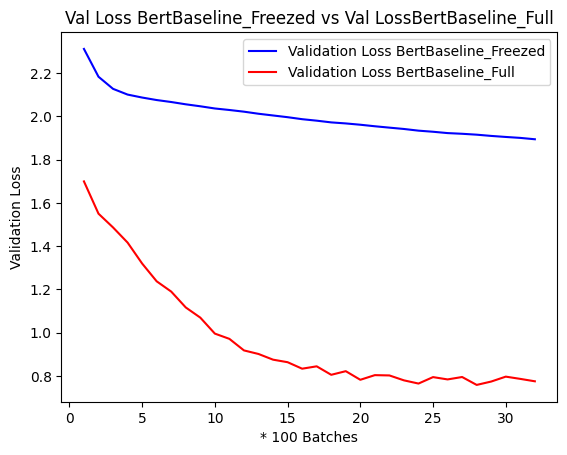

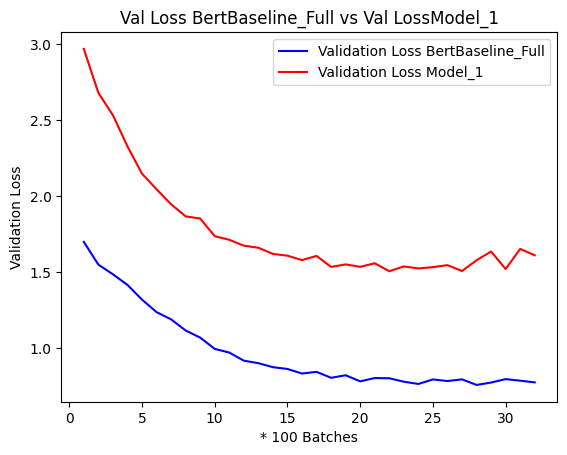

In [33]:
def plot_loss(loss1, loss2, name1, name2):
    epochs = range(1, len(loss1) + 1)

    plt.plot(epochs, loss1, 'b-', label=f'Validation Loss {name1}')
    plt.plot(epochs, loss2, 'r-', label=f'Validation Loss {name2}')
    plt.title(f'Val Loss {name1} vs Val Loss{name2}')
    plt.xlabel('* 100 Batches')
    plt.ylabel('Validation Loss')
    plt.legend()

    plt.show()

plot_loss(val_loss_freez, val_loss_full, 'BertBaseline_Freezed', 'BertBaseline_Full')
plot_loss(val_loss_full, val_loss_model1, 'BertBaseline_Full', 'Model_1')

#### **5.2 Confusion matrices**

In [34]:
def get_true_labels(label, df):
  true_labels = [item for sublist in df[label] for item in sublist]
  return true_labels

emotion_true_labels = get_true_labels('emotion_labels', test)
trigger_true_labels = get_true_labels('trigger_labels', test)

In [35]:
# Get the predictions
emotion_predictions_model1_tensors, _, trigger_predictions_model1_tensors, _ = model1.predict(test_dataloader)
emotion_predictions_baselinefull_tensors, _, trigger_predictions_baselinefull_tensors, _ = full_baseline.predict(test_dataloader)
emotion_predictions_baselinefreezed_tensors, _, trigger_predictions_baselinefreezed_tensors, _ = freezed_baseline.predict(test_dataloader)

emotion_predictions_model1 = [value.item() for tensor in emotion_predictions_model1_tensors for value in tensor]
emotion_predictions_baselinefull = [value.item() for tensor in emotion_predictions_baselinefull_tensors for value in tensor]
emotion_predictions_baselinefreezed = [value.item() for tensor in emotion_predictions_baselinefreezed_tensors for value in tensor]

trigger_predictions_model1 = [value.item() for tensor in trigger_predictions_model1_tensors for value in tensor]
trigger_predictions_baselinefull = [value.item() for tensor in trigger_predictions_baselinefull_tensors for value in tensor]
trigger_predictions_baselinefreezed = [value.item() for tensor in trigger_predictions_baselinefreezed_tensors for value in tensor]

# Decode them
emotion_predictions_model1_decoded = [reverse_emotion_mapping[label] for label in emotion_predictions_model1]
emotion_predictions_baselinefull_decoded = [reverse_emotion_mapping[label] for label in emotion_predictions_baselinefull]
emotion_predictions_baselinefreezed_decoded = [reverse_emotion_mapping[label] for label in emotion_predictions_baselinefreezed]

emotion_true_labels_decoded = [reverse_emotion_mapping[label] for label in emotion_true_labels]

In [36]:
print(reverse_emotion_mapping)
emotion_labels = list(reverse_emotion_mapping.values())

reverse_trigger_mapping = {0: 'Not trigger', 1: 'Trigger'}

{0: 'joy', 1: 'anger', 2: 'neutral', 3: 'surprise', 4: 'disgust', 5: 'sadness', 6: 'fear'}


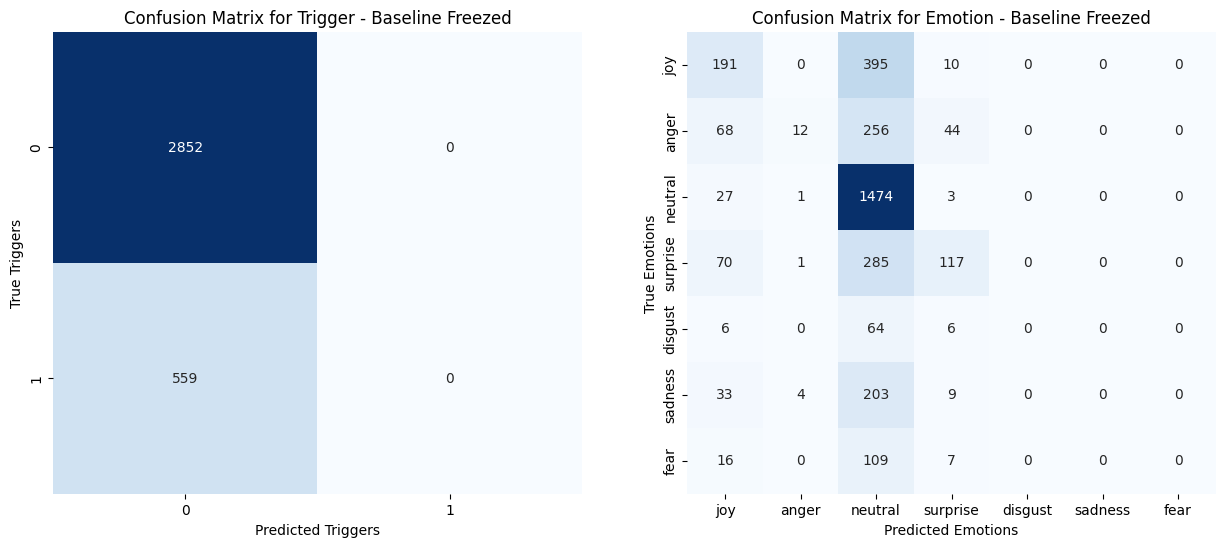

In [37]:
# Confusion matrices for freezed  baseline
conf_matrix_emotion_baselinefreezed = confusion_matrix(emotion_true_labels_decoded, emotion_predictions_baselinefreezed_decoded, labels=emotion_labels)
conf_matrix_trigger_baselinefreezed = confusion_matrix(trigger_true_labels, trigger_predictions_baselinefreezed)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix for Trigger - Model1
sns.heatmap(conf_matrix_trigger_baselinefreezed, annot=True, cbar=False, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted Triggers')
axs[0].set_ylabel('True Triggers')
axs[0].set_title('Confusion Matrix for Trigger - Baseline Freezed')

# Confusion Matrix for Emotion - Model1
sns.heatmap(conf_matrix_emotion_baselinefreezed, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels, ax=axs[1])
axs[1].set_xlabel('Predicted Emotions')
axs[1].set_ylabel('True Emotions')
axs[1].set_title('Confusion Matrix for Emotion - Baseline Freezed')

plt.show()

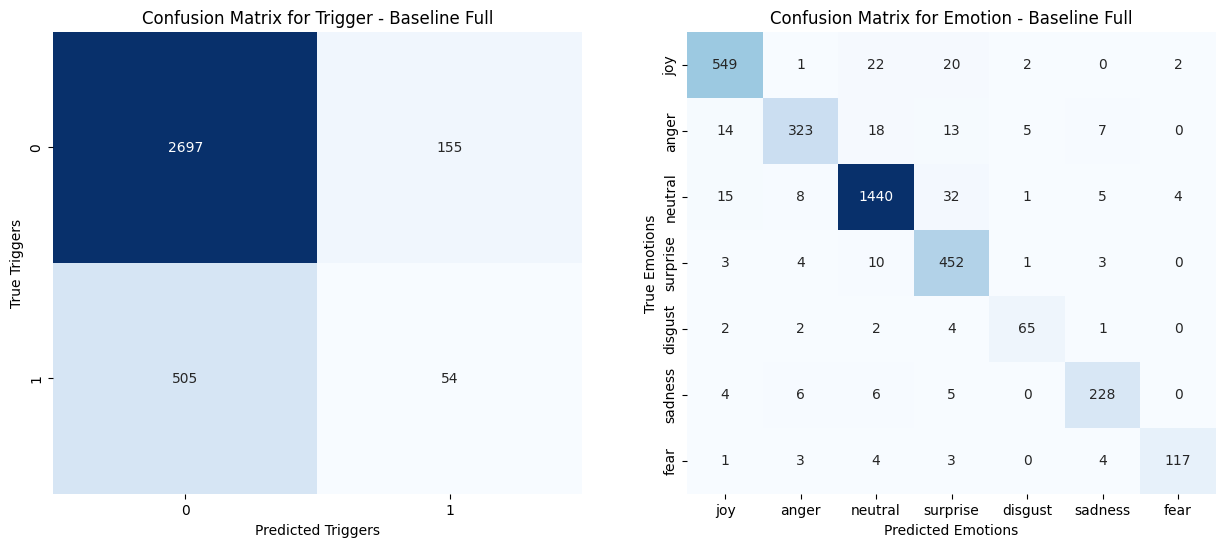

In [38]:
# Confusion matrices for baseline full
conf_matrix_emotion_baselinefull = confusion_matrix(emotion_true_labels_decoded, emotion_predictions_baselinefull_decoded, labels=emotion_labels)
conf_matrix_trigger_baselinefull = confusion_matrix(trigger_true_labels, trigger_predictions_baselinefull)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix for Trigger - Model1
sns.heatmap(conf_matrix_trigger_baselinefull, annot=True, cbar=False, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted Triggers')
axs[0].set_ylabel('True Triggers')
axs[0].set_title('Confusion Matrix for Trigger - Baseline Full')

# Confusion Matrix for Emotion - Model1
sns.heatmap(conf_matrix_emotion_baselinefull, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels, ax=axs[1])
axs[1].set_xlabel('Predicted Emotions')
axs[1].set_ylabel('True Emotions')
axs[1].set_title('Confusion Matrix for Emotion - Baseline Full')
plt.show()


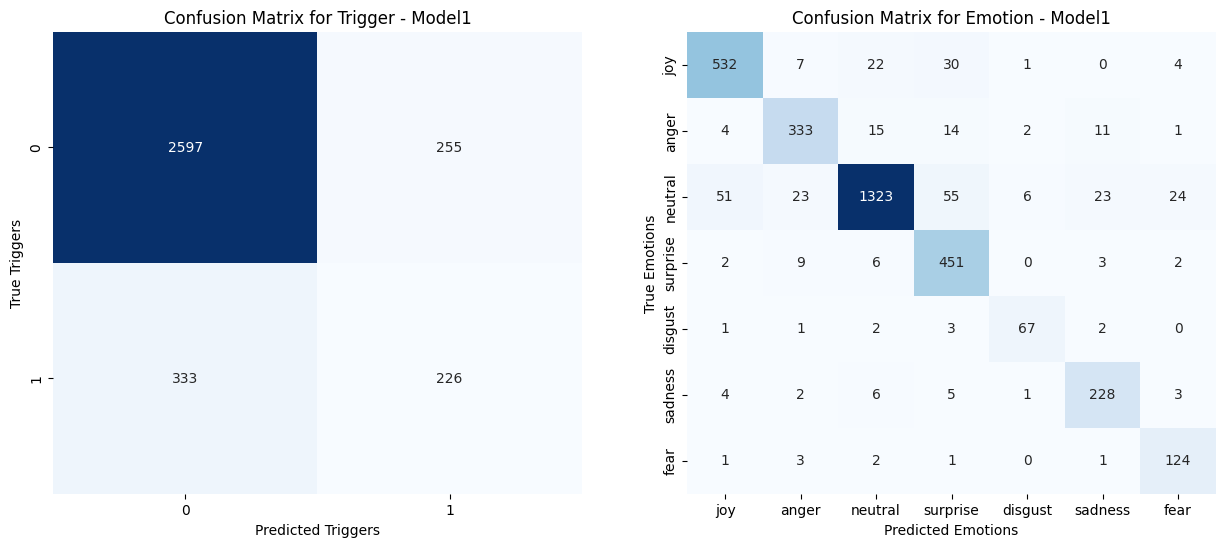

In [39]:
# Confusion matrices for model 1
conf_matrix_emotion_model1 = confusion_matrix(emotion_true_labels_decoded, emotion_predictions_model1_decoded, labels=emotion_labels)
conf_matrix_trigger_model1 = confusion_matrix(trigger_true_labels, trigger_predictions_model1)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix for Trigger - Model1
sns.heatmap(conf_matrix_trigger_model1, annot=True, cbar=False, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted Triggers')
axs[0].set_ylabel('True Triggers')
axs[0].set_title('Confusion Matrix for Trigger - Model1')

# Confusion Matrix for Emotion - Model1
sns.heatmap(conf_matrix_emotion_model1, annot=True, cbar=False, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels, ax=axs[1])
axs[1].set_xlabel('Predicted Emotions')
axs[1].set_ylabel('True Emotions')
axs[1].set_title('Confusion Matrix for Emotion - Model1')

plt.show()

#### **5.3 Plot some examples**

In [40]:
# Visualize some examples
def example_emotions(df, column, value, emotion_predictions_bfr, emotion_predictions_bfu, emotion_predictions_m1):
    dataframe = df[df[column] == value]
    dataframe = dataframe.drop(columns=['lunghezza', 'Text', 'trigger'])
    dataframe['emotion'] = dataframe['emotion'].map(reverse_emotion_mapping)
    rename_mapping = {'emotion' : 'true_emotion'}

    index = value - 3600
    e_predictions_bfr = [tensor.tolist() for tensor in emotion_predictions_bfr]
    e_predictions_bfu = [tensor.tolist() for tensor in emotion_predictions_bfu]
    e_predictions_m1 = [tensor.tolist() for tensor in emotion_predictions_m1]

    e_predictions_bfr = e_predictions_bfr[index]
    e_predictions_bfu = e_predictions_bfu[index]
    e_predictions_m1 = e_predictions_m1[index]

    new_order = ['episode', 'speaker', 'utterance', 'emotion']
    dataframe = dataframe[new_order]
    dataframe = dataframe.rename(columns=rename_mapping)

    dataframe['emotions_bert_freezed'] = e_predictions_bfr
    dataframe['emotions_bert_full'] = e_predictions_bfu
    dataframe['emotions_model1'] = e_predictions_m1

    dataframe['emotions_bert_freezed'] = dataframe['emotions_bert_freezed'].map(reverse_emotion_mapping)
    dataframe['emotions_bert_full'] = dataframe['emotions_bert_full'].map(reverse_emotion_mapping)
    dataframe['emotions_model1'] = dataframe['emotions_model1'].map(reverse_emotion_mapping)
    return dataframe

# The number must be between 3600 and 3999 (because those are the elements of test set)
example_emotions(df, 'lunghezza', 3603, emotion_predictions_baselinefreezed_tensors, emotion_predictions_baselinefull_tensors, emotion_predictions_model1_tensors)


,episode,speaker,utterance,true_emotion,emotions_bert_freezed,emotions_bert_full,emotions_model1
31614,utterance_2287,Joey,Do you have any respect for your body?,disgust,neutral,disgust,disgust
31615,utterance_2287,Ross,Don't you realise what you're-you're doing to ...,disgust,neutral,disgust,disgust
31616,utterance_2287,Chandler,"Hey, y'know, I have had it with you guys and y...",anger,neutral,anger,anger
31617,utterance_2287,Chandler,"The bottom line is, smoking is cool, and you k...",neutral,neutral,neutral,neutral
31618,utterance_2287,Rachel,"Chandler? It's Alan, he wants to speak to you.",neutral,neutral,neutral,neutral
31619,utterance_2287,Chandler,Really?,surprise,surprise,surprise,surprise
31620,utterance_2287,Chandler,He does?,surprise,neutral,surprise,surprise
31621,utterance_2287,Chandler,"Hey, buddy, what's up!",joy,neutral,joy,joy
31622,utterance_2287,Chandler,"Oh, she told you about that, huh.",surprise,neutral,surprise,surprise
31623,utterance_2287,Chandler,"Well, yeah, I have one now and then.",neutral,neutral,neutral,neutral


In [41]:
example_emotions(df, 'lunghezza', 3600, emotion_predictions_baselinefreezed_tensors, emotion_predictions_baselinefull_tensors, emotion_predictions_model1_tensors)

,episode,speaker,utterance,true_emotion,emotions_bert_freezed,emotions_bert_full,emotions_model1
31589,utterance_3263,Jim,And your breasts! Hmm!!!,surprise,joy,surprise,surprise
31590,utterance_3263,Phoebe,Okay.,neutral,neutral,neutral,neutral
31591,utterance_3263,Phoebe,"Umm look, you're coming on a little strong.",fear,neutral,fear,fear


In [42]:
def example_triggers(df, column, value, trigger_predictions_bfr, trigger_predictions_bfu, trigger_predictions_m1):
    dataframe = df[df[column] == value]
    dataframe = dataframe.drop(columns=['lunghezza', 'Text', 'emotion'])
    dataframe['trigger'] = dataframe['trigger'].map(reverse_trigger_mapping)
    rename_mapping = {'trigger' : 'true_trigger'}

    index = value - 3600
    t_predictions_bfr = [tensor.tolist() for tensor in trigger_predictions_bfr]
    t_predictions_bfu = [tensor.tolist() for tensor in trigger_predictions_bfu]
    t_predictions_m1 = [tensor.tolist() for tensor in trigger_predictions_m1]

    t_predictions_bfr = t_predictions_bfr[index]
    t_predictions_bfu = t_predictions_bfu[index]
    t_predictions_m1 = t_predictions_m1[index]

    new_order = ['episode', 'speaker', 'utterance', 'trigger']
    dataframe = dataframe[new_order]
    dataframe = dataframe.rename(columns=rename_mapping)

    dataframe['trigger_bert_freezed'] = t_predictions_bfr
    dataframe['trigger_bert_full'] = t_predictions_bfu
    dataframe['trigger_model1'] = t_predictions_m1

    dataframe['trigger_bert_freezed'] = dataframe['trigger_bert_freezed'].map(reverse_trigger_mapping)
    dataframe['trigger_bert_full'] = dataframe['trigger_bert_full'].map(reverse_trigger_mapping)
    dataframe['trigger_model1'] = dataframe['trigger_model1'].map(reverse_trigger_mapping)
    return dataframe

# The number must be between 3600 and 3999 (because those are the elements of test set)
example_triggers(df, 'lunghezza', 3601, trigger_predictions_baselinefreezed_tensors, trigger_predictions_baselinefull_tensors, trigger_predictions_model1_tensors)

,episode,speaker,utterance,true_trigger,trigger_bert_freezed,trigger_bert_full,trigger_model1
31592,utterance_620,1st Customer,Everything was delicious!,Not trigger,Not trigger,Not trigger,Not trigger
31593,utterance_620,Monica,Thank you!,Not trigger,Not trigger,Not trigger,Not trigger
31594,utterance_620,2nd Customer,It was. The duck in particular was superb.,Not trigger,Not trigger,Not trigger,Not trigger
31595,utterance_620,Monica,Thank you! You haven't said anything...,Not trigger,Not trigger,Not trigger,Not trigger
31596,utterance_620,3rd Customer,Actually I do have one small complaint.,Trigger,Not trigger,Not trigger,Not trigger
31597,utterance_620,Monica,Oh..please!I-I welcome criticism.,Not trigger,Not trigger,Not trigger,Not trigger


In [43]:
# The number must be between 3600 and 3999 (because those are the elements of test set)
example_triggers(df, 'lunghezza', 3700, trigger_predictions_baselinefreezed_tensors, trigger_predictions_baselinefull_tensors, trigger_predictions_model1_tensors)

,episode,speaker,utterance,true_trigger,trigger_bert_freezed,trigger_bert_full,trigger_model1
32441,utterance_2604,Ross,is for me not to see you anymore.,Not trigger,Not trigger,Trigger,Not trigger
32442,utterance_2604,Rachel,That's crazy!,Not trigger,Not trigger,Not trigger,Not trigger
32443,utterance_2604,Rachel,You can't do that!,Not trigger,Not trigger,Not trigger,Not trigger
32444,utterance_2604,Rachel,What are you going to tell her?,Not trigger,Not trigger,Not trigger,Not trigger
32445,utterance_2604,Rachel,Oh God.,Not trigger,Not trigger,Not trigger,Not trigger
32446,utterance_2604,Rachel,"Ohh, you already agreed to this, haven't you?",Not trigger,Not trigger,Trigger,Not trigger
32447,utterance_2604,Ross,"It's awful I know, I mean, I feel terrible but...",Not trigger,Not trigger,Not trigger,Not trigger
32448,utterance_2604,Ross,"And I do, I have to make",Not trigger,Not trigger,Not trigger,Not trigger
32449,utterance_2604,Rachel,Ohh! Lucky me! Oh my God! That,Not trigger,Not trigger,Not trigger,Not trigger
32450,utterance_2604,Ross,You have no idea what a nightmare this has bee...,Not trigger,Not trigger,Not trigger,Not trigger


#### **5.4 Comments**

##### Comparation in performance between models and baselines

To begin our analysis, we focus on evaluating the performance of the models and baseline approaches. Our observations reveal that the BERT freeze model exhibits limited effectiveness across both the classification tasks. Although there appears to be a relative performance increase for triggers, a closer examination of the confusion matrix exposes its behavior as a majority classifier, categorizing all examples as 0. Similarly, in emotion classification, a majority classifier behavior is evident, particularly for the neutral emotio, which in this case represents the majority class. This can certainly be linked to the fact that the classification heads are the only part that can be trained and they must be much more complex to achieve optimal performance.

On the contrary, the full BERT model excels in emotion classification to such an extent that no custom model surpasses its performance in this domain. Turning our attention to trigger classification, it is noteworthy that again majority classifier behavior emerges, predominantly influenced by the imbalanced distribution of class 0 instances in the dataset. We can highlight the fact that this time, by being able to train the entire architecture's parameters, the model was able to conquer the emotion classification task, and was not able to do the same on triggers not because it was not enough complex but because it did not had enough contextual information about the distribution of triggers. The emotion confusion matrix is very "clean" in fact we can see that the distribution of errors is equally distributed between classes more than being concentrated on particular categories: this made us think that the errors may be due to noise in the data more than on actual "incompetence" of the model, this will be discussed again in the next part about the custom model.
The last thing we want to highlight is that the observed optimal performance of bert full made us think that the bert models embeddings are so well suited for task like emotion classification that even with minor modification to the original bert architecture (in the case of bert full adding two classification layers) what strongly impact the performance is the bert body itself independently by the other part of the architecture.

Concluding the baselines discussion, both the simple random and majority classifiers exhibit comparable scores in trigger classification with respect to the bert baselines, however they have the lowest performance in emotion classification.


The custom classifier demonstrates the ability to diversify its learning by simultaneously addressing both classification tasks. It achieves comparable performance to full BERT in emotion classification and significantly outperforms it in trigger classification. This accomplishment is attributed to strategic choices aimed at contextualizing trigger learning:

 - The introduction of an LSTM layer and a more intricate trigger classification head (comprising three layers with a pyramidal reduction in the number of hidden units) with a ReLU activation in the initial part. The LTSM gave context within the dialogue to the model, this context was particularly useful for trigger because trigger depend on the previous and next sentence in order to predict a change in emotion. Also the classification head increased complexity was able to learn more complex patterns in the embeddings generated by the body bert.
 
 - Additionally, we experimented with concatenating the predicted emotion to the embeddings generated by the BERT architecture's body. This augmentation aimed to enrich trigger-specific information in the embeddings, thereby facilitating trigger prediction.

 Other than the f1-score values we also observed that the convergence speed of the custom model was way higher than any other model. In fact if we limited the training to one or two epochs (and this may be considered in case of limited time for training) the emotion score reached an interval of 0.7-0.8 while the one of full bert only 0.6. Also Weighted class were used in the loss functions (BCEloss and Crossentropy) significantly improving trigger classification. This was due to the fact that now the majority classes (in both tasks) had lower impact on the loss so classifying all example as belonging to them was no more interesting for the model, so it was able to explore different strategies.

##### Model discussion

Having established the superior performance of our custom model compared to the baselines, in particular for outperforming the BERT full model, we now turn our attention to a qualitative evaluation of its behaviour. Once again, we focus on the first model for the same reasons we highlighted previously (Ending part of section 4.2). The following key points are noteworthy:

 - Trigger Classification:
       The confusion matrix of the model indicates potential room for improvement. Many examples are misclassified but this is less concerning for the "0" labels, as over 90% of examples are correctly classified. A different situation can be observed for "1" labels where the misclassified examples are more than the correct ones. In order to solve this, more complex classification heads can be implemented or the weight of the 1 class can be increased in the loss function. One thing that emerged during trials was that using more than 1 ltsm layer for trigger lowered the performance.

 - Emotion Classification:
        Overall, the model demonstrates good performance in emotion classification. However, there is room for improvement in the "Neutral" and "Joy" classes. The misclassification rate for other classes is lower, indicating that further improvements may be challenging if strategies focusing on these classes were implemented. Regarding "Neutral," misclassifications are expected given the abundance of examples; however, the errors are negligible compared to the correctly classified instances. In contrast, the "Joy" class poses challenges due to its dependency on the specific context of joyous sentences. Instances where prior utterances set a context, altering the perceived sentiment of a sentence, contribute to a higher error rate in the "Joy" category compared to other classes. Further refinement in handling such contextual nuances may enhance the model's performance on joyous expressions. More than that, as we said when we were analysing the confusion matrix of the full bert, it seems that there is some noise/errors in the data in the form of "confusing" labels. An example of this can be obtained by analysing the following dialogue: 

          - Ross : she said what?
          - Emily : she said, "if i'm not gonna be happy getting married somewhere that we find in a day, well then we should just postpone it."
          - Ross : postpone it?
          - Ross : emily, do you think monica realises how much our parents spent on this wedding?
          - Ross : do you my sister's teeny-tiny little brain comprehends that people took time out of their lives to fly thousands of miles to be here, huh?
          - Ross : this isn't right.

      For a human observer it is quite obvious that ross is nervous and is getting angry at the idea that his sister is post-poning the wedding. However the ground truth tag in the data of the "postpone it?" utterance is "Joy" which can result confusing. The custom model assigned the "Neutral" tag to the utterance. This is for demostrating that the data can actually contain errors or noise and this will impact the performance of the model even if slightly.

